In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import os, sys

import matplotlib.pyplot as plt

In [2]:
## This are the configuration of all the parameters

ModelOutDIR = "Bsize64_lr5e-4_NOnormNodes/"
BatchSize = 1024
LearningRate = 0.0005
Epochs = 500


In [3]:
import os
## check if EOS folder exists otherwise use local folder
if os.path.exists("/eos/cms/store/user/folguera/L1TMuon/INTREPID/Graphs_v240725_241113/"):
    GraphDIR = "/eos/cms/store/user/folguera/L1TMuon/INTREPID/Graphs_v240725_241113/"
else:
    GraphDIR = "../../data/"

graph_name = 'vix_graph_13Nov_3_muonQOverPt' #"vix_graph_13Nov_3_muonQOverPt" #vix_graph_6Nov_3_muonQOverPt
num_files = 4
Allgraphs = []
all_files = os.listdir(GraphDIR)

# Filter for .pkl files
graph_files = [f for f in all_files if (f.endswith('.pkl') or f.endswith('.pt')) and graph_name in f]
print(f"Using files: {graph_files}")
if not graph_files:
    print("No .pkl/.pt files found in the directory.")
    sys.exit()

graph_files = graph_files[:num_files]

graphs = []
for graph_file in graph_files:
    file_path = os.path.join(GraphDIR, graph_file)
    print(f"Loading file: {graph_file}")
    if graph_file.endswith('.pt'):
        graph = torch.load(file_path)
    elif graph_file.endswith('.pkl'):
        with open(file_path, 'rb') as file:
            graph = torch.load(file)
    graphs.append(graph)

Using files: ['vix_graph_13Nov_3_muonQOverPt_006.pt', 'vix_graph_13Nov_3_muonQOverPt_002.pt', 'vix_graph_13Nov_3_muonQOverPt_003.pt', 'vix_graph_13Nov_3_muonQOverPt_007.pt', 'vix_graph_13Nov_3_muonQOverPt_008.pt', 'vix_graph_13Nov_3_muonQOverPt_009.pt', 'vix_graph_13Nov_3_muonQOverPt_004.pt', 'vix_graph_13Nov_3_muonQOverPt_005.pt', 'vix_graph_13Nov_3_muonQOverPt_001.pt']
Loading file: vix_graph_13Nov_3_muonQOverPt_006.pt


/var/folders/08/4qyj2h792lv7kk8b3phm_j000000gn/T/ipykernel_34668/122855456.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(file_path)


Loading file: vix_graph_13Nov_3_muonQOverPt_002.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_003.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_007.pt


## Load data

In [4]:
import torch_geometric.transforms as T
                   
Graphs_for_training = sum(graphs, [])
Graphs_for_training_reduced = Graphs_for_training
Graphs_for_training_filtered = [
    g for g in Graphs_for_training_reduced
    if not (torch.isnan(g.y).any() or torch.isnan(g.x).any())  and g.edge_index.size(1) > 0
]

for i in range(0, len(Graphs_for_training_filtered)):
    Graphs_for_training_filtered[i].y = Graphs_for_training_filtered[i].y.mean(dim=0)
    Graphs_for_training_filtered[i].edge_attr = torch.stack([Graphs_for_training_filtered[i].deltaPhi.float(), Graphs_for_training_filtered[i].deltaEta.float()], dim=1)        

# remove extra dimenson in y
print(f"Total Graphs: {len(Graphs_for_training)}")
print(f"Total Graphs after filtering: {len(Graphs_for_training_filtered)}")
for i in range(0, len(Graphs_for_training_filtered)):
    Graphs_for_training_filtered[i].y = Graphs_for_training_filtered[i].y.mean(dim=0)

for i in range(0, len(Graphs_for_training_filtered)):
    Graphs_for_training_filtered[i].y = Graphs_for_training_filtered[i].y.mean(dim=0)
    Graphs_for_training_filtered[i].edge_attr = torch.stack([Graphs_for_training_filtered[i].deltaPhi.float(), Graphs_for_training_filtered[i].deltaEta.float()], dim=1)        

Graphs_for_training_filtered = [
    g for g in Graphs_for_training_filtered
    if not (torch.isnan(g.x).any() or torch.isnan(g.edge_attr).any() or torch.isnan(g.y).any())
]
print(f"Total Graphs after filtering: {len(Graphs_for_training_filtered)}")



print("====================================")
print("Example of data:")
print(type(Graphs_for_training_filtered[0]))
print(Graphs_for_training_filtered[0].x)
print(Graphs_for_training_filtered[0].edge_index)
print(Graphs_for_training_filtered[0].edge_attr)
print(Graphs_for_training_filtered[0].y)
print("====================================")

Total Graphs: 225339
Total Graphs after filtering: 223141
Total Graphs after filtering: 223141
Example of data:
<class 'torch_geometric.data.data.Data'>
tensor([[1.0005e+00, 2.4179e+00, 4.3113e+02, 0.0000e+00, 3.0000e+00],
        [1.1310e+00, 2.3166e+00, 4.1368e+02, 1.0000e+01, 5.0000e+00],
        [1.0657e+00, 2.3225e+00, 4.4868e+02, 1.1000e+01, 5.0000e+00],
        [1.1092e+00, 2.3469e+00, 1.1241e+03, 7.0000e+00, 9.0000e+00],
        [1.0766e+00, 2.3318e+00, 1.1015e+03, 1.6000e+01, 5.0000e+00]],
       dtype=torch.float64)
tensor([[0, 0, 1, 1, 2, 2, 3, 4],
        [1, 2, 0, 2, 0, 1, 4, 3]])
tensor([[-0.1012,  0.1305],
        [-0.0954,  0.0653],
        [-0.1012,  0.1305],
        [ 0.0058, -0.0653],
        [-0.0954,  0.0653],
        [ 0.0058, -0.0653],
        [-0.0151, -0.0326],
        [-0.0151, -0.0326]])
tensor(-0.0836)


In [5]:
from torch_geometric.transforms import BaseTransform, Compose

class NormalizeNodeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'x'):
            data.x = (data.x - data.x.mean(dim=0)) / data.x.std(dim=0)
        return data

class NormalizeEdgeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'edge_attr'):
            data.edge_attr = (data.edge_attr - data.edge_attr.mean(dim=0)) / data.edge_attr.std(dim=0)
        return data

class NormalizeTargets(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'y'):
            data.y = (data.y - data.y.mean(dim=0)) / data.y.std(dim=0)
        return data

class DropLastTwoNodeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'x'):
            data.x = data.x[:, :-2]  # Eliminar las dos últimas columnas
        return data

# Definir las transformaciones
transform = Compose([
    NormalizeNodeFeatures(),
    NormalizeEdgeFeatures(),
    DropLastTwoNodeFeatures()  # Aplicar la transformación para eliminar las dos últimas características
])

# Aplicar las transformaciones a los datos
Graphs_for_training_filtered = [transform(data) for data in Graphs_for_training_filtered]


Graphs_for_training_filtered = [
    g for g in Graphs_for_training_filtered
    if not (torch.isnan(g.x).any() or torch.isnan(g.edge_attr).any() or torch.isnan(g.y).any())
]
print(f"Total Graphs after filtering: {len(Graphs_for_training_filtered)}")

print("====================================")
print("Example of (transformed) data:")
print(Graphs_for_training_filtered[0].x)
print(Graphs_for_training_filtered[0].edge_index)
print(Graphs_for_training_filtered[0].edge_attr)
print(Graphs_for_training_filtered[0].y)
print("====================================")

Total Graphs after filtering: 215664
Example of (transformed) data:
tensor([[-1.5275,  1.7185, -0.7298],
        [ 1.0911, -0.7405, -0.7765],
        [-0.2182, -0.5992, -0.6829],
        [ 0.6547, -0.0057,  1.1248],
        [ 0.0000, -0.3731,  1.0644]], dtype=torch.float64)
tensor([[0, 0, 1, 1, 2, 2, 3, 4],
        [1, 2, 0, 2, 0, 1, 4, 3]])
tensor([[-0.9804,  1.2748],
        [-0.8657,  0.4903],
        [-0.9804,  1.2748],
        [ 1.1295, -1.0786],
        [-0.8657,  0.4903],
        [ 1.1295, -1.0786],
        [ 0.7167, -0.6864],
        [ 0.7167, -0.6864]])
tensor(-0.0836)


In [6]:
# Load data
events = len(Graphs_for_training_filtered)
ntrain = int((events * 0.7) / BatchSize) * BatchSize  # to have full batches
print(f"Training events: {ntrain}")

train_dataset = Graphs_for_training_filtered[:ntrain]
test_dataset = Graphs_for_training_filtered[ntrain:ntrain * 2]

train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BatchSize, shuffle=False)

Training events: 150528


### Validate graphs

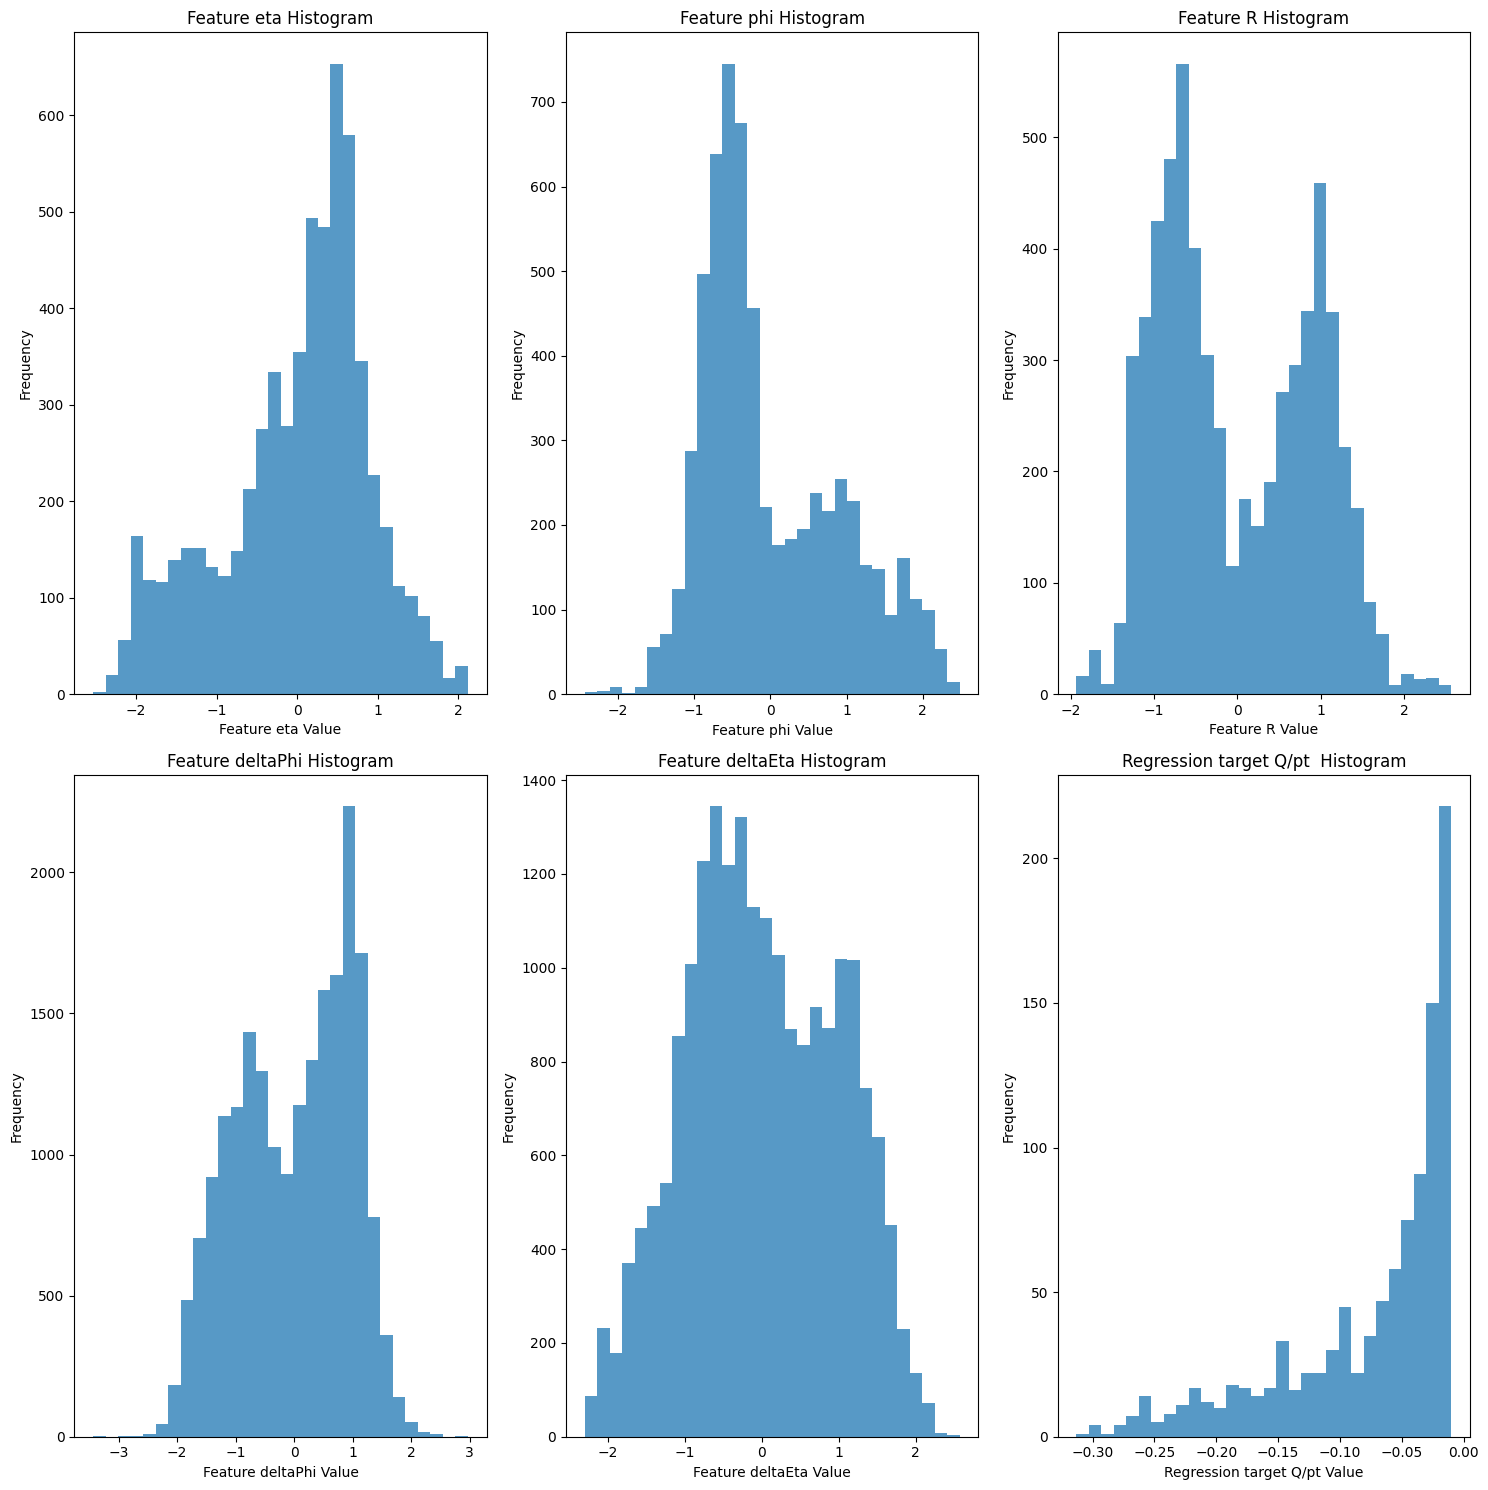

In [7]:
import matplotlib.pyplot as plt

# Function to plot histograms for each feature in the same figure

def plot_histograms(data_loader):   
    feature_names = ["eta", "phi", "R",  "deltaPhi", "deltaEta","Q/pt"]
    for batch in data_loader:
        features = batch.x.numpy()
        regression = batch.y.numpy()
        num_features = features.shape[1]
        fig, axs = plt.subplots(2, 3, figsize=(15, 15))
        axs = axs.flatten()
        
        # Plot node features
        for i in range(num_features):
            axs[i].hist(features[:, i], bins=30, alpha=0.75)
            axs[i].set_title(f'Feature {feature_names[i]} Histogram')
            axs[i].set_xlabel(f'Feature {feature_names[i]} Value')
            axs[i].set_ylabel('Frequency')
        
        
        # plot the number of edges of each graph
        for i in range(batch.edge_attr.shape[1]):
            axs[i+num_features].hist(batch.edge_attr[:, i], bins=30, alpha=0.75)
            axs[i+num_features].set_title(f'Feature {feature_names[i+num_features]} Histogram')
            axs[i+num_features].set_xlabel(f'Feature {feature_names[i+num_features]} Value')
            axs[i+num_features].set_ylabel('Frequency')
        
        # Plot regression target
        axs[num_features + (batch.edge_attr.shape[1])].hist(regression, bins=30, alpha=0.75)
        axs[num_features + (batch.edge_attr.shape[1])].set_title(f'Regression target {feature_names[-1]}  Histogram')
        axs[num_features + (batch.edge_attr.shape[1])].set_xlabel(f'Regression target {feature_names[-1]} Value')
        axs[num_features + (batch.edge_attr.shape[1])].set_ylabel('Frequency')
              
        plt.tight_layout()
        plt.show()
        break  # Only draw the first batch

# Plot histograms for training data
plot_histograms(train_loader)

## Define model

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_max_pool, global_mean_pool
from torch_geometric.utils import add_self_loops, degree

class MPNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPNNLayer, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.edge_lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Linearly transform node feature matrix.
        x = self.lin(x)

        # Start propagating messages.
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j has shape [E, out_channels]
        # edge_attr has shape [E, in_channels]
        return x_j + self.edge_lin(edge_attr)

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

class MPNNRegressor(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, output_dim=1):
        super(MPNNRegressor, self).__init__()
        self.conv1 = MPNNLayer(num_node_features, hidden_dim)
        self.conv2 = MPNNLayer(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x.float(), data.edge_index, data.edge_attr, data.batch

        # Asegurarse de que edge_attr tenga las dimensiones correctas
        if edge_attr is not None:
            edge_attr = edge_attr.float()

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)
        x = self.fc1(x)
        return x

In [9]:
class GATRegressor(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim, output_dim=1):
        super(GATRegressor, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_dim, add_self_loops=False)
        self.conv2 = GATConv(hidden_dim, hidden_dim, add_self_loops=False)
        self.fc1 = torch.nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x.float(), data.edge_index, data.edge_attr, data.batch
        
        x = F.relu(x)
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)
        x = self.fc1(x)
        return x

## Train model

In [10]:
# Definir el modelo, optimizador y la función de pérdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATRegressor(num_node_features=3, hidden_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

# Definir una función para entrenar el modelo
def train_model(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y.view(out.size()))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Definir una función para evaluar el modelo
@torch.no_grad()
def evaluate_model(model, test_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        loss = loss_fn(out, data.y.view(out.size()))
        total_loss += loss.item()
    return total_loss / len(test_loader)


# imprimir y pintar el MODELO
print(model)


GATRegressor(
  (conv1): GATConv(3, 16, heads=1)
  (conv2): GATConv(16, 16, heads=1)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


In [11]:
# Entrenar y evaluar el modelo
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
    test_loss = evaluate_model(model, test_loader, loss_fn, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.0092, Test Loss: 0.0049
Epoch 2/10, Train Loss: 0.0048, Test Loss: 0.0044
Epoch 3/10, Train Loss: 0.0043, Test Loss: 0.0041
Epoch 4/10, Train Loss: 0.0041, Test Loss: 0.0040
Epoch 5/10, Train Loss: 0.0040, Test Loss: 0.0039
Epoch 6/10, Train Loss: 0.0039, Test Loss: 0.0038
Epoch 7/10, Train Loss: 0.0039, Test Loss: 0.0038
Epoch 8/10, Train Loss: 0.0038, Test Loss: 0.0038
Epoch 9/10, Train Loss: 0.0038, Test Loss: 0.0037
Epoch 10/10, Train Loss: 0.0037, Test Loss: 0.0037


In [ ]:
# Save the model
if not os.path.exists(ModelOutDIR):
    os.makedirs(ModelOutDIR)

torch.save(model.state_dict(), ModelOutDIR + "model.pt")




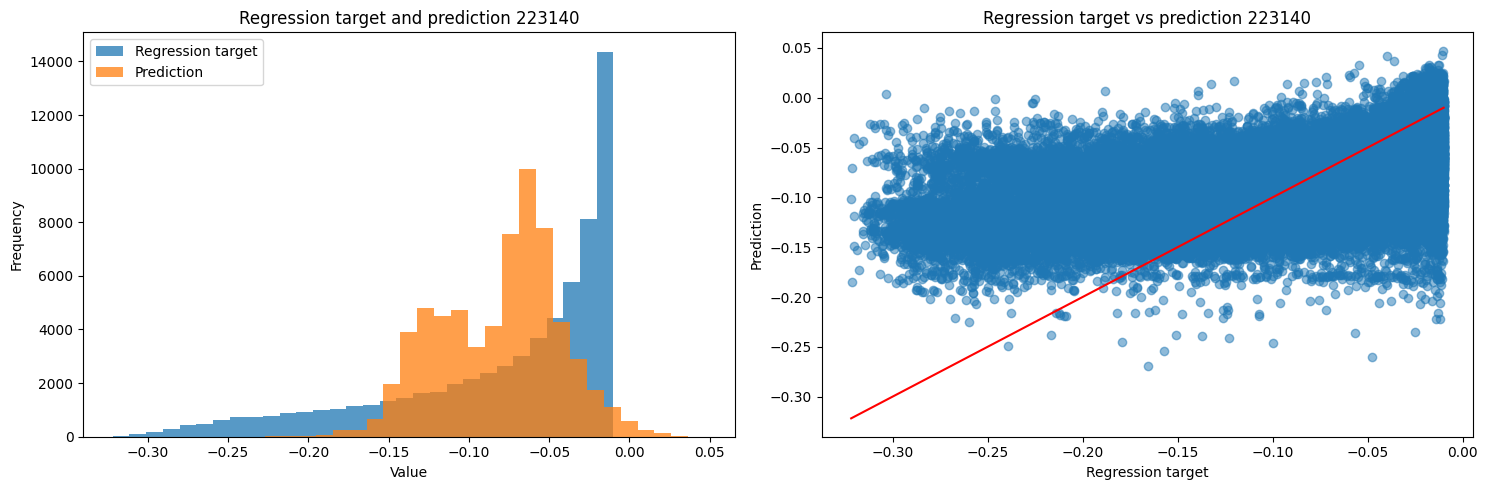

In [31]:
## Plot the results
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    all_regression = []
    all_prediction = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            all_regression.append(data.y.cpu().numpy())
            all_prediction.append(out.cpu().numpy())
    
    
    # Concatenar todas las predicciones y valores objetivo
    all_regression = np.concatenate(all_regression, axis=0)
    all_prediction = np.concatenate(all_prediction, axis=0)
    
    return all_regression, all_prediction

def plot_results(all_regression, all_prediction):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].hist(all_regression, bins=30, alpha=0.75, label='Regression target')
    axs[0].hist(all_prediction, bins=30, alpha=0.75, label='Prediction')
    axs[ 0].set_title(f'Regression target and prediction {i}')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()

    axs[1].scatter(all_regression, all_prediction, alpha=0.5)
    axs[1].plot([min(all_regression), max(all_regression)], [min(all_regression), max(all_regression)], color='red')
    axs[1].set_title(f'Regression target vs prediction {i}')
    axs[1].set_xlabel('Regression target')
    axs[1].set_ylabel('Prediction')
    plt.tight_layout()
    plt.show()


all_regression, all_prediction = evaluate_model(model, test_loader, device)
plot_results(all_regression, all_prediction)
